# Analysis for SDDIR vs RISDD

In [1]:
import rushd as rd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
# Required descriptors for annotate
from scipy.stats import ttest_ind
from statannotations.stats.StatTest import StatTest
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

In [4]:
base_datadir = rd.datadir/'2024.09.02_reprogramming_1-2'

experimentdir1 = base_datadir/'2024.09.02_reprogramming'
experimentdir2 = base_datadir/'2024.09.30_reprogramming'

figpath = '../figures/fig3/'

# Load Data

In [5]:
df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv',yaml_path=experimentdir1/'metadata.yaml')
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv',yaml_path=experimentdir2/'metadata.yaml')

data_14dpi_all = pd.concat([df1,df2])

data_14dpi_all['condition'] = data_14dpi_all['cassette'] + ' ' + data_14dpi_all['JNKi']

# Remove negative data
data_14dpi_all = data_14dpi_all.loc[(data_14dpi_all['GFP-A'] > 0)]

# Get just JNKi = 0
data_14dpi = data_14dpi_all.loc[data_14dpi_all.JNKi == '0 uM'].reset_index()


# GFP gate

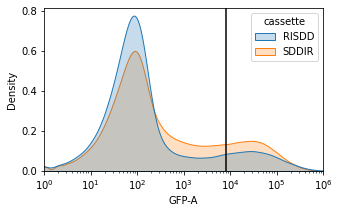

In [6]:
# Threshold for iMNs
GFP_thresh = 8e3

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot
x = 'GFP-A'
hue = 'cassette'

sns.kdeplot(ax=ax, data=data_14dpi,
    x=x, hue=hue,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Title
# plt.suptitle('14 dpi')
# Adjust limits
eGFP_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

sub_ax.axvline(GFP_thresh, 0, 1, color='black')

In [7]:
# Categorize iMNs based on eGFP_thresh
data_14dpi['GFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['GFP-A'] > GFP_thresh), 'GFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-H+
well_group = ['cassette', 'rep']

count_df_reps = data_14dpi.groupby([*well_group, 'well', 'GFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['GFP_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps = data_iMN_yield_reps.loc[data_iMN_yield_reps['GFP_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SDDIR vs. RISDD: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:2.662e-02 Stat=2.401e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


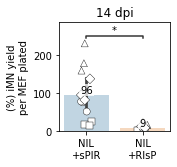

In [8]:
# General plotting params
x = 'cassette'
order = ['SDDIR', 'RISDD']
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 
units = 'well'

# Plot iMN yield per MEF plated
fig, ax = plt.subplots(1, 1, figsize=(2,2))
y = 'yield'
sns.barplot(ax=ax, data=data_iMN_yield_reps,
            x=x, y=y, order=order, units=units,
            alpha=0.3)

# Plot reps
for (i, rep) in enumerate(data_iMN_yield_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_yield_reps[data_iMN_yield_reps.rep == rep],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        color='white', size=7,
        edgecolor='black', linewidth=0.4,)
    
# Add stats
pairs = [('SDDIR', 'RISDD')]
annot = Annotator(ax=ax, data=data_iMN_yield, x=x, y=y, pairs=pairs, order=order)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()


# # Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=0)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))
    
# Format
plt.title('14 dpi')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
plt.xticks(rotation=0)
# label_map = {
#     'RISDD': 'NIL+\nHRAS$G12V$-IRES-SNAPp53DD',
#     'SDDIR': 'NIL+\nSNAPp53DD-IRES-HRAS$G12V$',
# }
label_map = {
    'RISDD': 'NIL\n+RIsP',
    'SDDIR': 'NIL\n+sPIR',
}
ax.set_xticklabels([label_map[label] for label in order])

# plt.savefig(figpath + 'SI/SDDRRopt_iMN_yield.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SDDIR vs. RISDD: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:1.585e-01 Stat=1.092e+00


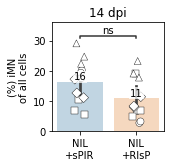

In [9]:
# General plotting params
x = 'cassette'
order = ['SDDIR', 'RISDD']
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 
units = 'well'

# Plot iMN yield per MEF plated
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
y = 'percent'
sns.barplot(ax=ax, data=data_iMN_percent_reps,
            x=x, y=y, order=order, units=units,
            alpha=0.3)

# Plot reps
for (i, rep) in enumerate(data_iMN_percent_reps.rep.unique()):
    sns.stripplot(
        ax=ax, data=data_iMN_percent_reps[data_iMN_percent_reps.rep == rep],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        color='white', size=7,
        edgecolor='black', linewidth=0.4,)
    
# Add stats
pairs = [('SDDIR', 'RISDD')]
annot = Annotator(ax=ax, data=data_iMN_percent, x=x, y=y, pairs=pairs, order=order)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# # Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=0)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))
    
# Format
plt.title('14 dpi')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
label_map = {
    'RISDD': 'NIL\n+RIsP',
    'SDDIR': 'NIL\n+sPIR',
}
ax.set_xticklabels([label_map[label] for label in order])
# ax.set_yticks(np.arange(0, 40, 10))
# plt.savefig(figpath + 'SI/SDDRRopt_iMN_percent.svg', bbox_inches='tight')